In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from scipy.special import erfc
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from torch.optim import SGD, Adam
from tqdm import tqdm
from utils import Encoder, Decoder, awgn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [3]:
M = 16 # number of constellation points
flag_train_model = False # True: train model, False: load pre-trained model
Path = "./models/ae_simo_rayleigh_16qam.pth"
encoder = Encoder([M, 64, 64, 64, 2]).to(device)
decoder = Decoder([8, 512, 512, 512, M]).to(device)

In [4]:
if flag_train_model:
    train_snr = 15 # training SNR in dB
    criterion = nn.NLLLoss()     # negative log likelihood loss
    para = list(encoder.parameters()) + list(decoder.parameters())  # get all parameters
    opt = Adam(para, lr=0.01)
    loss = []  # store the loss value
    totEpoch = int(1e4)  # total number of epochs
    iteration = tqdm(range(totEpoch), desc="loss")

    for iterator in iteration:
        iteration.set_description("epoch={:}".format(iterator))
        messages = torch.randint(0, M, size=(51200,), device=device)  # generate
        one_hot = F.one_hot(messages, M).float()  # convert to one hot encoding shape=(16000, M)
        tx =encoder(one_hot)

        ch_real1 = torch.randn(tx.shape[0]).to(device)
        ch_imag1 = torch.randn(tx.shape[0]).to(device)
        ch_real2 = torch.randn(tx.shape[0]).to(device)
        ch_imag2 = torch.randn(tx.shape[0]).to(device)
        csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)

        rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
        rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
        rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
        rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])

        rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)

        rx = awgn(rx, train_snr)

        rx = torch.cat((rx, csi), dim=1)

        y_pred = decoder(rx)

        cross_entropy = criterion(y_pred, messages)

        opt.zero_grad()
        cross_entropy.backward()
        opt.step()

        loss.append(cross_entropy.item())


    # plot the loss
    plt.figure()
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the model
    torch.save({
            'Encoder': encoder.state_dict(),
            'Decoder': decoder.state_dict(),
            }, Path)
    print("Model saved")



In [5]:
SNR_dB = np.arange(0, 20, 1)

# Monte Carlo simulation of the SER for the trained model
SER = np.array([])
for snr in SNR_dB:
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr or totSym < minSym:
        messages = torch.randint(0, M, size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        ch_real1 = torch.randn(tx.shape[0]).to(device)
        ch_imag1 = torch.randn(tx.shape[0]).to(device)
        ch_real2 = torch.randn(tx.shape[0]).to(device)
        ch_imag2 = torch.randn(tx.shape[0]).to(device)
        csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)
        rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
        rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
        rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
        rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])
        rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)
        rx = awgn(rx, snr)
        rx = torch.cat((rx, csi), dim=1)
        y_pred = decoder(rx)
        pred = torch.argmax(y_pred, 1)
        err = (pred != messages).sum()
        totErr += err.cpu()
        totSym += num_mess
    SER = np.append(SER, totErr / totSym)
    print("SNR: ", snr, "SER: ", SER[-1])

# Monte Carlo simulation of the SER for the Maximum Ratio Combining (MRC) receiver
SER_mrc = np.array([])
for snr in SNR_dB:
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr or totSym < minSym:
        messages = torch.randint(0, M, size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        ch_real1 = torch.randn(tx.shape[0]).to(device)
        ch_imag1 = torch.randn(tx.shape[0]).to(device)
        ch_real2 = torch.randn(tx.shape[0]).to(device)
        ch_imag2 = torch.randn(tx.shape[0]).to(device)
        csi = torch.stack((ch_real1, ch_imag1, ch_real2, ch_imag2), dim=1)
        rx_real1 = torch.mul(ch_real1, tx[:, 0]) - torch.mul(ch_imag1, tx[:, 1])
        rx_imag1 = torch.mul(ch_imag1, tx[:, 0]) + torch.mul(ch_real1, tx[:, 1])
        rx_real2 = torch.mul(ch_real2, tx[:, 0]) - torch.mul(ch_imag2, tx[:, 1])
        rx_imag2 = torch.mul(ch_imag2, tx[:, 0]) + torch.mul(ch_real2, tx[:, 1])
        rx = torch.stack((rx_real1, rx_imag1, rx_real2, rx_imag2), dim=1)
        rx = awgn(rx, snr)
        rx = torch.cat((rx, csi), dim=1)
        rx = rx[:, 0:2] + rx[:, 2:4]
        pred = torch.argmin((rx[:, 0:2] - M)**2, 1)
        err = (pred != messages).sum()
        totErr += err.cpu()
        totSym += num_mess
    SER_mrc = np.append(SER_mrc, totErr / totSym)
    print("SNR: ", snr, "SER MRC: ", SER_mrc[-1])


plt.figure()
plt.plot(SNR_dB, SER, "o-")
plt.yscale("log")
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.grid()

SNR:  0 SER:  0.9382832646369934
SNR:  1 SER:  0.9382344484329224
SNR:  2 SER:  0.9375696778297424
SNR:  3 SER:  0.9381946921348572
SNR:  4 SER:  0.9376950860023499
SNR:  5 SER:  0.9379886388778687
SNR:  6 SER:  0.9373049139976501
SNR:  7 SER:  0.937886118888855
SNR:  8 SER:  0.9381290078163147
SNR:  9 SER:  0.9380434155464172
SNR:  10 SER:  0.9382284879684448
SNR:  11 SER:  0.9378065466880798
SNR:  12 SER:  0.9375179409980774
SNR:  13 SER:  0.9376890659332275
SNR:  14 SER:  0.9382623434066772
SNR:  15 SER:  0.937974750995636
SNR:  16 SER:  0.9380801916122437
SNR:  17 SER:  0.9379319548606873
SNR:  18 SER:  0.9377129673957825
SNR:  19 SER:  0.938396692276001


RuntimeError: The size of tensor a (16) must match the size of tensor b (2) at non-singleton dimension 1

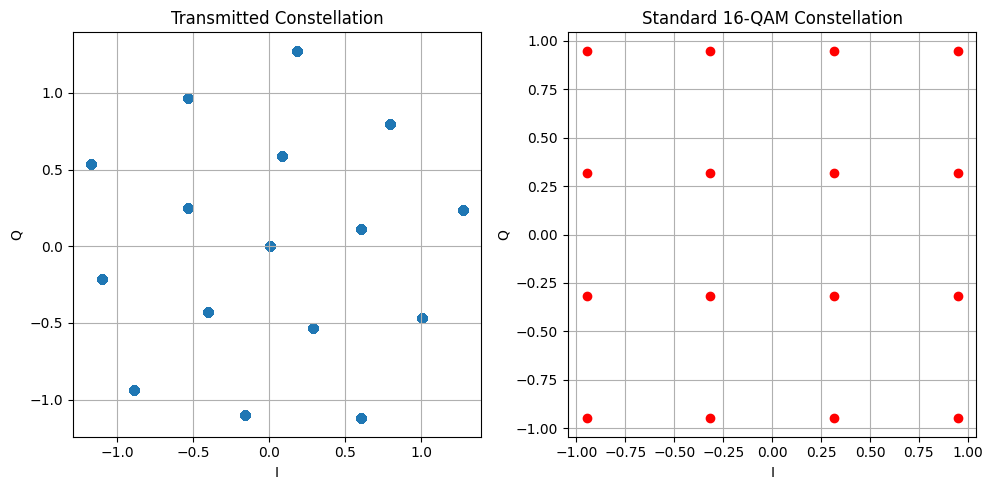

In [ ]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, M, size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(10)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(10)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()